Epoch 1/100, Loss: 0.6622, Accuracy: 71.03%
Epoch 2/100, Loss: 0.3617, Accuracy: 88.36%
Epoch 3/100, Loss: 0.3165, Accuracy: 89.63%
Epoch 4/100, Loss: 0.3067, Accuracy: 90.66%
Epoch 5/100, Loss: 0.2986, Accuracy: 92.27%
Epoch 6/100, Loss: 0.2902, Accuracy: 92.23%
Epoch 7/100, Loss: 0.2871, Accuracy: 92.42%
Epoch 8/100, Loss: 0.2896, Accuracy: 91.72%
Epoch 9/100, Loss: 0.2886, Accuracy: 93.10%
Epoch 10/100, Loss: 0.2836, Accuracy: 93.03%
Epoch 11/100, Loss: 0.2815, Accuracy: 92.99%
Epoch 12/100, Loss: 0.2820, Accuracy: 93.33%
Epoch 13/100, Loss: 0.2788, Accuracy: 93.43%
Epoch 14/100, Loss: 0.2775, Accuracy: 93.11%
Epoch 15/100, Loss: 0.2774, Accuracy: 93.08%
Epoch 16/100, Loss: 0.2793, Accuracy: 92.27%
Epoch 17/100, Loss: 0.2760, Accuracy: 92.81%
Epoch 18/100, Loss: 0.2762, Accuracy: 93.48%
Epoch 19/100, Loss: 0.2782, Accuracy: 93.14%
Epoch 20/100, Loss: 0.2782, Accuracy: 92.89%
Epoch 21/100, Loss: 0.2755, Accuracy: 93.50%
Epoch 22/100, Loss: 0.2789, Accuracy: 93.73%
Epoch 23/100, Loss:

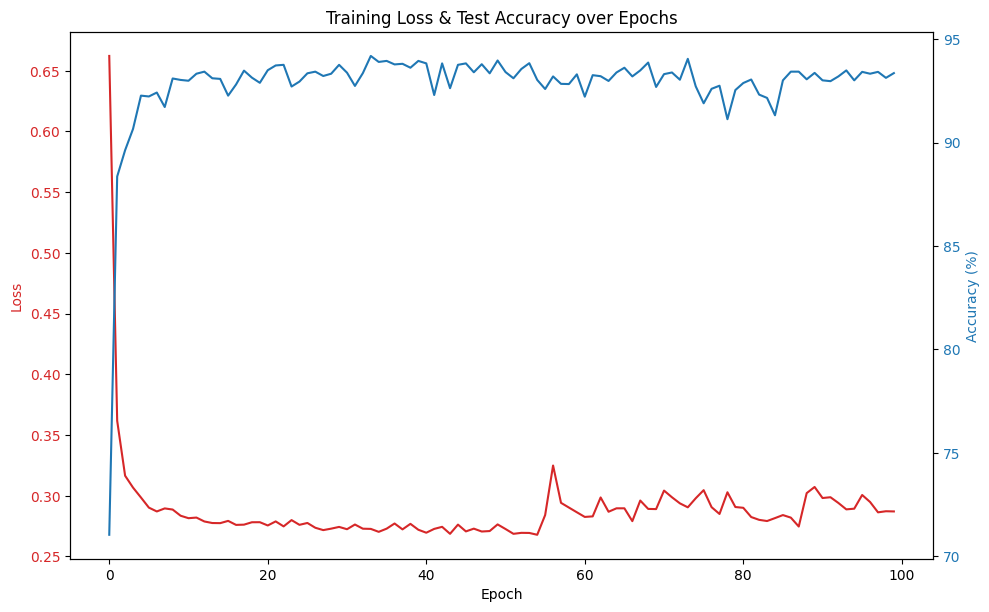

In [21]:
# Implements the Forward-Forward Algorithm
# https://arxiv.org/abs/2212.13345
# The algorithm replaces backpropagation's forward and backward passes with two forward passes on different data with opposite objectives.

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparams
BATCH_SIZE = 512
TEST_BATCH_SIZE = 1000
EPOCHS = 100
LEARNING_RATE = 0.03
THRESHOLD = 2.0
WEIGHT_DECAY = 0.000001

# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

class FFLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.activation(self.linear(x_direction))

    def compute_goodness(self, x):
        x = self.forward(x)
        return x.pow(2).mean(1) # sum of squared activations

class FFNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(FFNetwork, self).__init__()
        self.layers = nn.ModuleList([FFLayer(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])

    def forward(self, x):
        goodnesses = []
        for layer in self.layers:
            goodness = layer.compute_goodness(x)
            goodnesses.append(goodness)
            x = layer(x)
        return torch.stack(goodnesses, dim=1)

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = inject_label_into_input(x, label)
            goodness = self.forward(h).sum(1) 
            goodness_per_label.append(goodness.unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

def inject_label_into_input(x, y, classes=10): 
    # One-hot encoding
    x_ = x.clone()
    x_[:, :classes] *= 0.0
    if isinstance(y, int):
        y = torch.full((x.shape[0],), y, dtype=torch.long, device=x.device)
    x_[range(x.shape[0]), y] = x.max()
    return x_ 

def train(model, train_loader, optimizer, threshold, device):
    model.train()
    total_loss = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)

        x_pos = inject_label_into_input(data, target)
        g_pos = model(x_pos).mean(1)

        y_neg = torch.randint(0, 10, target.shape, device=device)
        x_neg = inject_label_into_input(data, y_neg)
        g_neg = model(x_neg).mean(1)

        loss = torch.log(1 + torch.exp(torch.cat([-g_pos + threshold, g_neg - threshold]))).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            pred = model.predict(data)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    return 100. * correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFNetwork([784, 500, 500]).to(device) # 784 = 28*28 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, THRESHOLD, device)
    accuracy = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)

# Visualize
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(test_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss & Test Accuracy over Epochs')
plt.show()